In [1]:
import pandas as pd
import numpy as np
import pickle
import re
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize

In [2]:
# Display setting for dataframe in notebook
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)
decimal = 5
pd.set_option('display.float_format', lambda x: f'%.{decimal}f' % x)

# Import Data

In [3]:
# df_FS = pd.read_pickle("./data_pickle/data_FS.pkl")

In [4]:
df_FS = pd.read_pickle("./data_pickle/data_FS_v1.pkl")

In [5]:
#Check number of 0 value
def miss_checker(data: pd.DataFrame, fig_size=(15,10)):
    nobs = data.shape[0]
    feature = data.columns
    abs_missing = (data==0).sum().to_list()
    ratio_missing = 100*((data==0).sum()/ nobs)
    tab = pd.DataFrame({'Column': feature, 
                        'Abs_missing': abs_missing,
                        'Percent_missing': ratio_missing})
#     tab.sort_values('Abs_missing', inplace=True)
#     tab.plot.barh(x='Column', y='Percent_missing', rot = 0, figsize=fig_size)
    
    return tab

In [6]:
miss_checker(df_FS)

,Column,Abs_missing,Percent_missing
Ticker,Ticker,0,0.00000
ComGroupCode,ComGroupCode,0,0.00000
en_OrganName,en_OrganName,0,0.00000
YearReport_t0,YearReport_t0,0,0.00000
YearReport_t1,YearReport_t1,0,0.00000
YearReport_t2,YearReport_t2,0,0.00000
CurrentAsset_t0,CurrentAsset_t0,0,0.00000
CurrentAsset_t1,CurrentAsset_t1,0,0.00000
CurrentAsset_t2,CurrentAsset_t2,0,0.00000
CashAndEquivalent_t0,CashAndEquivalent_t0,0,0.00000


In [7]:
def list_denominators(df_FS, config):
    denominators = set()
    pattern = re.compile(r"/\s*(\w+(?:\s*\+\s*\w+)*)")

    for formula in config['formula']:
        # Find all denominators in the formula
        matches = pattern.findall(formula)
        for match in matches:
            parts = [part.strip() for part in match.split('+')]
            for part in parts:
                if part in df_FS.columns:
                    denominators.add(part)
    
    return list(denominators)

In [8]:
def calculate_score(df_FS, config, col_denom):
    df_score = pd.DataFrame()
    df_score['Ticker'] = df_FS['Ticker']
    
    df_used = df_FS.copy()
    df_used[col_denom] = df_used[col_denom].fillna(0.00001)
    df_used[col_denom] = df_used[col_denom].replace(0, 0.00001)

    for index, row in config.iterrows():
        new_col = row['new_col']
        formula = row['formula']
        for old_col in df_used.columns:
            formula = formula.replace(old_col, f"df_used['{old_col}']")
        df_score[new_col] = eval(formula)
        
    return df_score

In [9]:
def winsorize(data, lower_pct, upper_pct):
    data = pd.to_numeric(data, errors='coerce')
    
    lower_limit = data.quantile(lower_pct)
    upper_limit = data.quantile(upper_pct)
    
    data[data < lower_limit] = lower_limit
    data[data > upper_limit] = upper_limit
    
    return data

# Calculate long list features

In [10]:
config = pd.read_excel("./data/config_longlist.xlsx")
config

,new_col,formula
0,OP/SAL,OperatingProfit_t0 / RevenueNet_t0
1,EBIT/TA,OperatingProfit_t0/ TotalAssets_t0
2,GP/FA,GrossProfit_t0 / PPE_t0
3,NI/CS,NetIncome_t0 / CostOfSales_t0
4,GP/SAL,GrossProfit_t0 / RevenueNet_t0
5,GP/TA,GrossProfit_t0 / TotalAssets_t0
6,NI/EQ,NetIncome_t0 / TotalEquity_t0
7,CS/GP,CostOfSales_t0 / GrossProfit_t0
8,GP/CS,GrossProfit_t0 / CostOfSales_t0
9,NI/TA,NetIncome_t0 / TotalAssets_t0


In [11]:
col_denom = list_denominators(df_FS, config)
col_denom

['SGA_t0',
 'SGA_t1',
 'TotalAssets_t0',
 'NetIncome_t0',
 'CurrentAsset_t0',
 'CFO_t0',
 'TotalEquity_t0',
 'RevenueNet_t0',
 'Liability_ST_t0',
 'TotalLiability_t0',
 'CostOfSales_t1',
 'CostOfSales_t0',
 'GrossProfit_t0',
 'PPE_t0']

In [12]:
#Manually adjust for better SAL/CS, SAL/COST, SAL/GA, add RevenueNet_t1 to col_denom
col_denom.append('RevenueNet_t1')
col_denom

['SGA_t0',
 'SGA_t1',
 'TotalAssets_t0',
 'NetIncome_t0',
 'CurrentAsset_t0',
 'CFO_t0',
 'TotalEquity_t0',
 'RevenueNet_t0',
 'Liability_ST_t0',
 'TotalLiability_t0',
 'CostOfSales_t1',
 'CostOfSales_t0',
 'GrossProfit_t0',
 'PPE_t0',
 'RevenueNet_t1']

In [13]:
df_score = calculate_score(df_FS, config, col_denom)
df_score.describe()

,OP/SAL,EBIT/TA,GP/FA,NI/CS,GP/SAL,GP/TA,NI/EQ,CS/GP,GP/CS,NI/TA,OP/GP,RE/TA,NI/SAL,TAc/TA,CFO/CS,CFO/SAL,NI/CFO,CFO/TA,CFO/NI,LEV,WC/TA,CASH/CL,CASH/CA,CASH/TA,CA/CL,CL/TL,BV/TL,CA/TL,CFO/TL,EQ/TA,EQ/LA,(CA– INV)/CL,SAL/FA,SAL/TA,FA/TA,SAL/CS,SAL/COST,SAL/GA,INV/TA,INV/CA,INV/CS,REC/REV
count,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000
mean,-9677076507922.25977,0.04630,35083519032894.70312,-7966603102533.01953,0.21943,0.14603,0.06415,-9.66894,1029944767376.00098,0.03063,-9677076508530.45508,-0.26222,-8285599892956.85645,-0.02463,-136461620178271.64062,-136674404424295.54688,3.71268,0.05526,-17.23035,0.61182,0.08039,0.52323,0.15626,0.08294,2.91790,0.82063,3.09231,2.36626,0.19294,0.38820,NaN,2.44958,152072860158751.53125,1.04320,0.22776,-623084524157.78955,744167489025.91040,-12708317325773.59570,0.15942,0.25863,67725729331682.23438,308049907856327.12500
std,169148918521156.34375,0.10291,957776631155572.62500,261253637752135.87500,1.02246,0.15157,1.29557,37.41584,29054801931380.10547,0.13214,169148918521115.50000,4.14800,260980092666456.78125,0.16510,3811569890470113.50000,3811552136662018.50000,86.92867,0.14578,735.90276,1.51056,1.49805,2.20415,0.16810,0.10037,7.50676,0.24002,9.28476,6.25768,1.44080,1.51057,NaN,7.46818,3751749973094456.50000,1.18901,0.23144,25524193392163.79688,21007716709748.44531,755244125779942.12500,0.16261,0.22462,2367557043212026.00000,8630637278227711.00000
min,-4615272242600000.00000,-1.20765,-3129024688699999.50000,-7311309621799999.00000,-6.87261,-0.73137,-37.97985,-821.37250,-20.09666,-3.04894,-4615272242600000.00000,-117.19732,-7311309621799999.00000,-2.96422,-121622066955299984.00000,-121622066955299984.00000,-236.23378,-1.01049,-29161.72761,0.00694,-41.13358,0.00003,0.00007,0.00007,0.01325,0.02529,-0.97606,0.00849,-28.08396,-40.77334,-inf,0.00700,-250049179499999.96875,-0.02755,0.00000,-1019700486600000.00000,-8641349853639.74512,-29156800190619844.00000,0.00000,0.00000,-1329.89345,-146.44508
25%,0.00795,0.00563,0.26250,-0.14435,0.08095,0.04917,0.01654,-9.72406,-0.36884,0.00462,0.14502,0.00595,0.00631,-0.08145,-0.21271,-0.01409,-0.08818,-0.00910,-0.28838,0.29227,0.03010,0.04114,0.03341,0.01657,1.06849,0.72342,0.46060,0.79603,-0.01643,0.31535,0.79209,0.62866,1.91341,0.32884,0.04217,0.96315,0.96603,0.81004,0.02289,0.06287,-0.33442,0.11807
50%,0.04258,0.03899,0.84292,-0.04059,0.15088,0.11054,0.07268,-4.96345,-0.17324,0.03106,0.37941,0.04425,0.03395,-0.02181,-0.07314,0.06122,0.28882,0.04739,0.93395,0.49771,0.16491,0.15013,0.09810,0.04835,1.40792,0.94285,1.00921,1.19530,0.09803,0.50229,1.33244,1.04662,5.92364,0.75169,0.14725,1.00202,1.00027,0.97767,0.11280,0.21230,-0.14400,0.25795
75%,0.10643,0.08748,2.49489,-0.00699,0.27613,0.20347,0.14593,-2.20930,-0.08397,0.06984,0.64000,0.10108,0.10426,0.04135,0.01398,0.16436,0.81007,0.12825,2.72950,0.68465,0.36414,0.39581,0.21924,0.11090,2.38987,0.99834,2.42145,2.00062,0.32241,0.70773,2.36024,1.85193,17.71359,1.32593,0.34492,1.03347,1.02246,1.15781,0.25079,0.39733,-0.04060,0.60091
max,28.74770,1.22795,35030316291399996.00000,4015226668899999.50000,27.09917,1.34012,26.01000,342.74871,941936543299999.87500,1.27391,293.14618,0.78992,4015226668899999.50000,0.90961,350499582400000.00000,343621437300000.00000,2801.19110,0.96353,1493.83707,41.77334,0.98584,63.08885,0.98822,0.71821,159.70772,1.07788,143.14305,130.12082,21.77778,0.99306,inf,159.70772,144898214830400000.00000,16.52964,0.96814,23769400000000.00000,803222328496844.12500,7689359080824533.00000,0.91985,0.96465,94125502411000000.00000,321249812620099968.00000


In [14]:
#Manually adjust some ratios EQ/LA
df_score['Assets_LT_tmp'] = (df_FS['TotalAssets_t0'] - df_FS['CurrentAsset_t0']).replace(0, 0.00001)
df_score['EQ/LA'] = df_FS['TotalEquity_t0'] / df_score['Assets_LT_tmp']
df_score.drop(columns='Assets_LT_tmp', inplace=True)
df_score.describe()

,OP/SAL,EBIT/TA,GP/FA,NI/CS,GP/SAL,GP/TA,NI/EQ,CS/GP,GP/CS,NI/TA,OP/GP,RE/TA,NI/SAL,TAc/TA,CFO/CS,CFO/SAL,NI/CFO,CFO/TA,CFO/NI,LEV,WC/TA,CASH/CL,CASH/CA,CASH/TA,CA/CL,CL/TL,BV/TL,CA/TL,CFO/TL,EQ/TA,EQ/LA,(CA– INV)/CL,SAL/FA,SAL/TA,FA/TA,SAL/CS,SAL/COST,SAL/GA,INV/TA,INV/CA,INV/CS,REC/REV
count,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000
mean,-9677076507922.25977,0.04630,35083519032894.70312,-7966603102533.01953,0.21943,0.14603,0.06415,-9.66894,1029944767376.00098,0.03063,-9677076508530.45508,-0.26222,-8285599892956.85645,-0.02463,-136461620178271.64062,-136674404424295.54688,3.71268,0.05526,-17.23035,0.61182,0.08039,0.52323,0.15626,0.08294,2.91790,0.82063,3.09231,2.36626,0.19294,0.38820,443884771632.08710,2.44958,152072860158751.53125,1.04320,0.22776,-623084524157.78955,744167489025.91040,-12708317325773.59570,0.15942,0.25863,67725729331682.23438,308049907856327.12500
std,169148918521156.34375,0.10291,957776631155572.62500,261253637752135.87500,1.02246,0.15157,1.29557,37.41584,29054801931380.10547,0.13214,169148918521115.50000,4.14800,260980092666456.78125,0.16510,3811569890470113.50000,3811552136662018.50000,86.92867,0.14578,735.90276,1.51056,1.49805,2.20415,0.16810,0.10037,7.50676,0.24002,9.28476,6.25768,1.44080,1.51057,19807489456049.08984,7.46818,3751749973094456.50000,1.18901,0.23144,25524193392163.79688,21007716709748.44531,755244125779942.12500,0.16261,0.22462,2367557043212026.00000,8630637278227711.00000
min,-4615272242600000.00000,-1.20765,-3129024688699999.50000,-7311309621799999.00000,-6.87261,-0.73137,-37.97985,-821.37250,-20.09666,-3.04894,-4615272242600000.00000,-117.19732,-7311309621799999.00000,-2.96422,-121622066955299984.00000,-121622066955299984.00000,-236.23378,-1.01049,-29161.72761,0.00694,-41.13358,0.00003,0.00007,0.00007,0.01325,0.02529,-0.97606,0.00849,-28.08396,-40.77334,-78700994300000.00000,0.00700,-250049179499999.96875,-0.02755,0.00000,-1019700486600000.00000,-8641349853639.74512,-29156800190619844.00000,0.00000,0.00000,-1329.89345,-146.44508
25%,0.00795,0.00563,0.26250,-0.14435,0.08095,0.04917,0.01654,-9.72406,-0.36884,0.00462,0.14502,0.00595,0.00631,-0.08145,-0.21271,-0.01409,-0.08818,-0.00910,-0.28838,0.29227,0.03010,0.04114,0.03341,0.01657,1.06849,0.72342,0.46060,0.79603,-0.01643,0.31535,0.79209,0.62866,1.91341,0.32884,0.04217,0.96315,0.96603,0.81004,0.02289,0.06287,-0.33442,0.11807
50%,0.04258,0.03899,0.84292,-0.04059,0.15088,0.11054,0.07268,-4.96345,-0.17324,0.03106,0.37941,0.04425,0.03395,-0.02181,-0.07314,0.06122,0.28882,0.04739,0.93395,0.49771,0.16491,0.15013,0.09810,0.04835,1.40792,0.94285,1.00921,1.19530,0.09803,0.50229,1.33244,1.04662,5.92364,0.75169,0.14725,1.00202,1.00027,0.97767,0.11280,0.21230,-0.14400,0.25795
75%,0.10643,0.08748,2.49489,-0.00699,0.27613,0.20347,0.14593,-2.20930,-0.08397,0.06984,0.64000,0.10108,0.10426,0.04135,0.01398,0.16436,0.81007,0.12825,2.72950,0.68465,0.36414,0.39581,0.21924,0.11090,2.38987,0.99834,2.42145,2.00062,0.32241,0.70773,2.36024,1.85193,17.71359,1.32593,0.34492,1.03347,1.02246,1.15781,0.25079,0.39733,-0.04060,0.60091
max,28.74770,1.22795,35030316291399996.00000,4015226668899999.50000,27.09917,1.34012,26.01000,342.74871,941936543299999.87500,1.27391,293.14618,0.78992,4015226668899999.50000,0.90961,350499582400000.00000,343621437300000.00000,2801.19110,0.96353,1493.83707,41.77334,0.98584,63.08885,0.98822,0.71821,159.70772,1.07788,143.14305,130.12082,21.77778,0.99306,787584974099999.87500,159.70772,144898214830400000.00000,16.52964,0.96814,23769400000000.00000,803222328496844.12500,7689359080824533.00000,0.91985,0.96465,94125502411000000.00000,

In [15]:
for col in df_score.columns[1:]:
    df_score[col] = winsorize(df_score[col], 0.01, 0.98)
df_score.describe()

,OP/SAL,EBIT/TA,GP/FA,NI/CS,GP/SAL,GP/TA,NI/EQ,CS/GP,GP/CS,NI/TA,OP/GP,RE/TA,NI/SAL,TAc/TA,CFO/CS,CFO/SAL,NI/CFO,CFO/TA,CFO/NI,LEV,WC/TA,CASH/CL,CASH/CA,CASH/TA,CA/CL,CL/TL,BV/TL,CA/TL,CFO/TL,EQ/TA,EQ/LA,(CA– INV)/CL,SAL/FA,SAL/TA,FA/TA,SAL/CS,SAL/COST,SAL/GA,INV/TA,INV/CA,INV/CS,REC/REV
count,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000
mean,-0.12555,0.04562,5.99177,-0.16718,0.19156,0.14464,0.07219,-8.74484,-0.31954,0.03285,-0.58190,-0.05902,-0.21130,-0.02357,-0.17304,-0.03565,0.27702,0.05477,0.16793,0.50910,0.15646,0.38370,0.15414,0.08100,2.43148,0.82094,2.47506,1.92870,0.17998,0.47103,2.27657,1.96147,49.44864,1.00377,0.22660,0.98848,0.98890,1.06234,0.15760,0.25721,-0.51276,1.09759
std,1.52530,0.07665,21.61166,0.76289,0.20228,0.13395,0.15443,15.17564,0.49542,0.07691,7.35586,0.57038,2.09994,0.12829,1.16625,0.80221,3.92637,0.13008,18.61369,0.29299,0.39720,0.65244,0.16049,0.09204,3.00558,0.23886,4.16310,2.40281,0.56891,0.38854,3.70012,2.86391,192.13764,0.96033,0.22815,0.17954,0.18976,0.59128,0.15672,0.22083,1.61753,3.18530
min,-13.45187,-0.22438,-1.74947,-5.68411,-0.61776,-0.08372,-0.68776,-108.67831,-3.00427,-0.29831,-66.76214,-4.33844,-19.31641,-0.47398,-8.97960,-6.32413,-20.99855,-0.35388,-136.24015,0.02639,-2.43502,0.00080,0.00092,0.00067,0.09833,0.11078,-0.66567,0.04792,-2.20922,-1.99322,-6.76710,0.04699,0.01859,0.00028,0.00000,0.07909,0.09371,-0.12404,0.00000,0.00000,-13.01786,0.00969
25%,0.00795,0.00563,0.26250,-0.14435,0.08095,0.04917,0.01654,-9.72406,-0.36884,0.00462,0.14502,0.00595,0.00631,-0.08145,-0.21271,-0.01409,-0.08818,-0.00910,-0.28838,0.29227,0.03010,0.04114,0.03341,0.01657,1.06849,0.72342,0.46060,0.79603,-0.01643,0.31535,0.79209,0.62866,1.91341,0.32884,0.04217,0.96315,0.96603,0.81004,0.02289,0.06287,-0.33442,0.11807
50%,0.04258,0.03899,0.84292,-0.04059,0.15088,0.11054,0.07268,-4.96345,-0.17324,0.03106,0.37941,0.04425,0.03395,-0.02181,-0.07314,0.06122,0.28882,0.04739,0.93395,0.49771,0.16491,0.15013,0.09810,0.04835,1.40792,0.94285,1.00921,1.19530,0.09803,0.50229,1.33244,1.04662,5.92364,0.75169,0.14725,1.00202,1.00027,0.97767,0.11280,0.21230,-0.14400,0.25795
75%,0.10643,0.08748,2.49489,-0.00699,0.27613,0.20347,0.14593,-2.20930,-0.08397,0.06984,0.64000,0.10108,0.10426,0.04135,0.01398,0.16436,0.81007,0.12825,2.72950,0.68465,0.36414,0.39581,0.21924,0.11090,2.38987,0.99834,2.42145,2.00062,0.32241,0.70773,2.36024,1.85193,17.71359,1.32593,0.34492,1.03347,1.02246,1.15781,0.25079,0.39733,-0.04060,0.60091
max,0.78185,0.24000,141.74847,1.31916,0.75517,0.57146,0.43523,8.77654,0.41775,0.20728,3.08952,0.34866,0.69002,0.29994,2.72035,0.95721,14.08697,0.40426,44.96875,1.53983,0.79301,3.42717,0.65082,0.41251,16.36860,1.00000,21.60266,13.30638,2.11261,0.95576,20.45699,15.75635,1282.35572,4.57482,0.84014,1.49498,1.59557,3.65777,0.59237,0.80289,-0.00000,19.47346


In [16]:
df_score.head()

,Ticker,OP/SAL,EBIT/TA,GP/FA,NI/CS,GP/SAL,GP/TA,NI/EQ,CS/GP,GP/CS,NI/TA,OP/GP,RE/TA,NI/SAL,TAc/TA,CFO/CS,CFO/SAL,NI/CFO,CFO/TA,CFO/NI,LEV,WC/TA,CASH/CL,CASH/CA,CASH/TA,CA/CL,CL/TL,BV/TL,CA/TL,CFO/TL,EQ/TA,EQ/LA,(CA– INV)/CL,SAL/FA,SAL/TA,FA/TA,SAL/CS,SAL/COST,SAL/GA,INV/TA,INV/CA,INV/CS,REC/REV
0,A32,0.05785,0.08632,0.66586,-0.06488,0.10925,0.16301,0.17384,-8.15347,-0.12265,0.08623,0.52955,0.12661,0.05779,0.07747,-0.00659,0.00587,9.83866,0.00876,0.10164,0.50395,0.22653,0.18026,0.12436,0.09084,1.44950,1.00000,0.98431,1.44950,0.01739,0.49605,1.84050,0.67556,6.09490,1.49209,0.24481,0.99933,1.00778,1.15423,0.39003,0.53394,-0.29346,0.16720
1,AAA,0.04767,0.04132,0.34603,-0.04257,0.10459,0.09066,0.07037,-8.56136,-0.11680,0.03304,0.45580,0.06637,0.03812,-0.03844,-0.09209,0.08246,0.46229,0.07148,2.16313,0.53043,0.08440,0.25544,0.21435,0.11246,1.19169,0.83002,0.88527,0.98913,0.13476,0.46957,0.98787,0.94074,3.30851,0.86687,0.26201,1.00622,1.02065,1.24760,0.11049,0.21059,-0.14234,0.24811
2,AAM,-0.13155,-0.07543,0.01826,0.09912,0.00122,0.00070,-0.06166,-108.67831,-0.00122,-0.05677,-66.76214,-0.00949,-0.09900,0.05855,0.20135,-0.20111,0.49225,-0.11532,2.03148,0.07930,0.73892,1.69371,0.15331,0.12456,11.04784,0.92735,11.61010,10.24519,-1.45418,0.92070,4.90932,3.34679,15.01593,0.57341,0.03819,0.94544,0.91798,0.71142,0.56634,0.69706,-0.98886,0.14225
3,AAS,0.02876,0.02223,5.10599,-0.00675,0.02221,0.01717,0.00959,-44.01779,-0.02272,0.00510,1.29493,0.04904,0.00660,-0.07023,-0.09969,0.09747,0.06773,0.07533,14.76504,0.46799,0.50338,0.85990,0.40713,0.38922,2.11212,0.96720,1.13682,2.04283,0.16096,0.53201,12.09566,2.11212,229.86042,0.77278,0.00336,0.50187,0.50985,1.11690,0.00000,0.00000,-0.00000,0.20867
4,AAT,0.08301,0.04110,0.12429,-0.05593,0.12573,0.06225,0.03304,-6.95349,-0.14381,0.02421,0.66023,0.13189,0.04890,0.02245,-0.00406,0.00355,13.77394,0.00176,0.07260,0.26718,0.13864,0.21399,0.11430,0.03402,1.87212,0.59499,2.74274,1.11389,0.00658,0.73282,1.04332,1.68777,0.98857,0.49511,0.50084,1.00375,0.99240,0.76007,0.02931,0.09847,-0.06770,0.52061


In [17]:
data = pd.read_excel("./data/features_list.xlsx", sheet_name=['Mscore', 'Fscore', 'Zscore'])
df_Mscore = data['Mscore']
df_Fscore = data['Fscore']
df_Zscore = data['Zscore']

In [18]:
df_score = pd.merge(df_score, df_Mscore.iloc[:, :-1], on='Ticker', how='inner')
df_score = pd.merge(df_score, df_Fscore.iloc[:, :-2], on='Ticker', how='inner')
df_score

,Ticker,OP/SAL,EBIT/TA,GP/FA,NI/CS,GP/SAL,GP/TA,NI/EQ,CS/GP,GP/CS,NI/TA,OP/GP,RE/TA,NI/SAL,TAc/TA,CFO/CS,CFO/SAL,NI/CFO,CFO/TA,CFO/NI,LEV,WC/TA,CASH/CL,CASH/CA,CASH/TA,CA/CL,CL/TL,BV/TL,CA/TL,CFO/TL,EQ/TA,EQ/LA,(CA– INV)/CL,SAL/FA,SAL/TA,FA/TA,SAL/CS,SAL/COST,SAL/GA,INV/TA,INV/CA,INV/CS,REC/REV,DSRI,AQI,DEPI,TATA,GMI,SGI,SGAI,LVGI,RSST,REC,INV,SOFTASSETS,CASHSALES,ROA,ISSUE
0,A32,0.05785,0.08632,0.66586,-0.06488,0.10925,0.16301,0.17384,-8.15347,-0.12265,0.08623,0.52955,0.12661,0.05779,0.07747,-0.00659,0.00587,9.83866,0.00876,0.10164,0.50395,0.22653,0.18026,0.12436,0.09084,1.44950,1.00000,0.98431,1.44950,0.01739,0.49605,1.84050,0.67556,6.09490,1.49209,0.24481,0.99933,1.00778,1.15423,0.39003,0.53394,-0.29346,0.16720,0.96777,0.99271,1.00000,0.07756,0.99968,1.12064,0.86638,0.91858,0.10974,0.01868,-0.00349,0.66435,1.00673,0.01850,0
1,AAA,0.04767,0.04132,0.34603,-0.04257,0.10459,0.09066,0.07037,-8.56136,-0.11680,0.03304,0.45580,0.06637,0.03812,-0.03844,-0.09209,0.08246,0.46229,0.07148,2.16313,0.53043,0.08440,0.25544,0.21435,0.11246,1.19169,0.83002,0.88527,0.98913,0.13476,0.46957,0.98787,0.94074,3.30851,0.86687,0.26201,1.00622,1.02065,1.24760,0.11049,0.21059,-0.14234,0.24811,1.64481,0.75879,1.19164,-0.03016,1.00294,0.56521,0.80154,1.15014,-0.05532,-0.01360,-0.00544,0.62553,0.89798,-0.00068,0
2,AAM,-0.13155,-0.07543,0.01826,0.09912,0.00122,0.00070,-0.06166,-108.67831,-0.00122,-0.05677,-66.76214,-0.00949,-0.09900,0.05855,0.20135,-0.20111,0.49225,-0.11532,2.03148,0.07930,0.73892,1.69371,0.15331,0.12456,11.04784,0.92735,11.61010,10.24519,-1.45418,0.92070,4.90932,3.34679,15.01593,0.57341,0.03819,0.94544,0.91798,0.71142,0.56634,0.69706,-0.98886,0.14225,2.45637,0.94042,1.14033,0.03989,0.97273,0.90140,1.40563,2.42235,-0.01297,0.04579,0.16780,0.83726,0.91047,-0.05918,0
3,AAS,0.02876,0.02223,5.10599,-0.00675,0.02221,0.01717,0.00959,-44.01779,-0.02272,0.00510,1.29493,0.04904,0.00660,-0.07023,-0.09969,0.09747,0.06773,0.07533,14.76504,0.46799,0.50338,0.85990,0.40713,0.38922,2.11212,0.96720,1.13682,2.04283,0.16096,0.53201,12.09566,2.11212,229.86042,0.77278,0.00336,0.50187,0.50985,1.11690,0.00000,0.00000,-0.00000,0.20867,2.33362,15.66364,0.96160,-0.05310,0.75373,0.52516,0.89533,1.78564,-0.50930,0.01683,0.00000,0.60742,0.86904,-0.18822,0
4,AAT,0.08301,0.04110,0.12429,-0.05593,0.12573,0.06225,0.03304,-6.95349,-0.14381,0.02421,0.66023,0.13189,0.04890,0.02245,-0.00406,0.00355,13.77394,0.00176,0.07260,0.26718,0.13864,0.21399,0.11430,0.03402,1.87212,0.59499,2.74274,1.11389,0.00658,0.73282,1.04332,1.68777,0.98857,0.49511,0.50084,1.00375,0.99240,0.76007,0.02931,0.09847,-0.06770,0.52061,1.04716,0.59763,1.00000,0.03934,1.00175,0.60675,1.31566,0.81051,-0.22272,-0.09916,-0.00106,0.46514,0.96184,-0.01035,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1592,XPH,-0.06113,-0.01499,0.28628,-0.00112,0.23359,0.05727,0.00022,-3.28105,-0.30478,0.00021,-0.26169,-0.16045,0.00086,0.13606,0.72299,-0.55411,-0.00155,-0.13584,-136.24015,0.02639,0.34522,1.50844,0.10503,0.03897,14.36231,0.98090,21.60266,13.30638,-2.20922,0.95576,1.54808,9.72034,1.22556,0.24516,0.20004,1.13931,1.21254,1.40295,0.11993,0.32321,-0.63827,0.40467,0.91159,1.17857,0.94157,0.12086,1.06045,0.96749,0.71278,1.48537,0.05843,-0.01392,-0.02652,0.76099,1.07057,0.08148,0
1593,YBC,0.04478,0.04359,0.15412,-0.00231,0.07194,0.07004,0.01515,-12.90044,-0.07752,0.00209,0.62240,-0.03946,0.00215,0.02408,0.02434,-0.02259,-0.09507,-0.02199,-10.51819,0.86198,-0.33153,0.01160,0.01968,0.00938,0.58968,0.93734,0.16012,0.55273,-0.02551,0.13802,0.26362,0.28057,2.14234,0.97358,0.45444,1.00376,1.00114,0.91185,0.24974,0.52419,-0.27641,0.22600,0.83668,0.74727,1.12244,0.06558,1.00181,0.97785,1.09667,1.03548,-0.00718,-0.04690,0.02122,0.53618,1.05866,-0.00051,0
1594,YBM,0.09132,0.09270,0.68948,-0.04516,0.30899,0.31365,0.07732,-2.23635,-0.44716,0.031

In [19]:
df_with_score = pd.merge(df_Mscore.iloc[:, [0, -1]], df_Fscore.iloc[:, [0, -1]], on='Ticker', how='inner')
df_with_score = pd.merge(df_with_score, df_Zscore.iloc[:, [0, -1]], on='Ticker', how='inner')
df_with_score = pd.merge(df_with_score, df_score, on='Ticker', how='inner')
df_with_score

,Ticker,mscore,fscore,zscore,OP/SAL,EBIT/TA,GP/FA,NI/CS,GP/SAL,GP/TA,NI/EQ,CS/GP,GP/CS,NI/TA,OP/GP,RE/TA,NI/SAL,TAc/TA,CFO/CS,CFO/SAL,NI/CFO,CFO/TA,CFO/NI,LEV,WC/TA,CASH/CL,CASH/CA,CASH/TA,CA/CL,CL/TL,BV/TL,CA/TL,CFO/TL,EQ/TA,EQ/LA,(CA– INV)/CL,SAL/FA,SAL/TA,FA/TA,SAL/CS,SAL/COST,SAL/GA,INV/TA,INV/CA,INV/CS,REC/REV,DSRI,AQI,DEPI,TATA,GMI,SGI,SGAI,LVGI,RSST,REC,INV,SOFTASSETS,CASHSALES,ROA,ISSUE
0,A32,-2.79397,0.49848,6.76237,0.05785,0.08632,0.66586,-0.06488,0.10925,0.16301,0.17384,-8.15347,-0.12265,0.08623,0.52955,0.12661,0.05779,0.07747,-0.00659,0.00587,9.83866,0.00876,0.10164,0.50395,0.22653,0.18026,0.12436,0.09084,1.44950,1.00000,0.98431,1.44950,0.01739,0.49605,1.84050,0.67556,6.09490,1.49209,0.24481,0.99933,1.00778,1.15423,0.39003,0.53394,-0.29346,0.16720,0.96777,0.99271,1.00000,0.07756,0.99968,1.12064,0.86638,0.91858,0.10974,0.01868,-0.00349,0.66435,1.00673,0.01850,0
1,AAA,-3.86643,0.37259,5.22722,0.04767,0.04132,0.34603,-0.04257,0.10459,0.09066,0.07037,-8.56136,-0.11680,0.03304,0.45580,0.06637,0.03812,-0.03844,-0.09209,0.08246,0.46229,0.07148,2.16313,0.53043,0.08440,0.25544,0.21435,0.11246,1.19169,0.83002,0.88527,0.98913,0.13476,0.46957,0.98787,0.94074,3.30851,0.86687,0.26201,1.00622,1.02065,1.24760,0.11049,0.21059,-0.14234,0.24811,1.64481,0.75879,1.19164,-0.03016,1.00294,0.56521,0.80154,1.15014,-0.05532,-0.01360,-0.00544,0.62553,0.89798,-0.00068,0
2,AAM,-3.63254,0.88322,19.75009,-0.13155,-0.07543,0.01826,0.09912,0.00122,0.00070,-0.06166,-108.67831,-0.00122,-0.05677,-66.76214,-0.00949,-0.09900,0.05855,0.20135,-0.20111,0.49225,-0.11532,2.03148,0.07930,0.73892,1.69371,0.15331,0.12456,11.04784,0.92735,11.61010,10.24519,-1.45418,0.92070,4.90932,3.34679,15.01593,0.57341,0.03819,0.94544,0.91798,0.71142,0.56634,0.69706,-0.98886,0.14225,2.45637,0.94042,1.14033,0.03989,0.97273,0.90140,1.40563,2.42235,-0.01297,0.04579,0.16780,0.83726,0.91047,-0.05918,0
3,AAS,1.69346,0.32348,8.05510,0.02876,0.02223,5.10599,-0.00675,0.02221,0.01717,0.00959,-44.01779,-0.02272,0.00510,1.29493,0.04904,0.00660,-0.07023,-0.09969,0.09747,0.06773,0.07533,14.76504,0.46799,0.50338,0.85990,0.40713,0.38922,2.11212,0.96720,1.13682,2.04283,0.16096,0.53201,12.09566,2.11212,229.86042,0.77278,0.00336,0.50187,0.50985,1.11690,0.00000,0.00000,-0.00000,0.20867,2.33362,15.66364,0.96160,-0.05310,0.75373,0.52516,0.89533,1.78564,-0.50930,0.01683,0.00000,0.60742,0.86904,-0.18822,0
4,AAT,-3.62432,0.19660,7.74551,0.08301,0.04110,0.12429,-0.05593,0.12573,0.06225,0.03304,-6.95349,-0.14381,0.02421,0.66023,0.13189,0.04890,0.02245,-0.00406,0.00355,13.77394,0.00176,0.07260,0.26718,0.13864,0.21399,0.11430,0.03402,1.87212,0.59499,2.74274,1.11389,0.00658,0.73282,1.04332,1.68777,0.98857,0.49511,0.50084,1.00375,0.99240,0.76007,0.02931,0.09847,-0.06770,0.52061,1.04716,0.59763,1.00000,0.03934,1.00175,0.60675,1.31566,0.81051,-0.22272,-0.09916,-0.00106,0.46514,0.96184,-0.01035,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1592,XPH,-2.79161,0.49522,27.57365,-0.06113,-0.01499,0.28628,-0.00112,0.23359,0.05727,0.00022,-3.28105,-0.30478,0.00021,-0.26169,-0.16045,0.00086,0.13606,0.72299,-0.55411,-0.00155,-0.13584,-136.24015,0.02639,0.34522,1.50844,0.10503,0.03897,14.36231,0.98090,21.60266,13.30638,-2.20922,0.95576,1.54808,9.72034,1.22556,0.24516,0.20004,1.13931,1.21254,1.40295,0.11993,0.32321,-0.63827,0.40467,0.91159,1.17857,0.94157,0.12086,1.06045,0.96749,0.71278,1.48537,0.05843,-0.01392,-0.02652,0.76099,1.07057,0.08148,0
1593,YBC,-3.15123,0.31644,1.40760,0.04478,0.04359,0.15412,-0.00231,0.07194,0.07004,0.01515,-12.90044,-0.07752,0.00209,0.62240,-0.03946,0.00215,0.02408,0.02434,-0.02259,-0.09507,-0.02199,-10.51819,0.86198,-0.33153,0.01160,0.01968,0.00938,0.58968,0.93734,0.16012,0.55273,-0.02551,0.13802,0.26362,0.28057,2.14234,0.97358,0.45444,1.00376,1.00114,0.91185,0.24974,0.52419,-0.27641,0.226

In [20]:
df_with_score.to_excel("./data/longlist_features.xlsx", index=False)

# Check correlation

In [21]:
correlation_matrix = df_with_score.corr()
correlation_matrix

/var/folders/x2/1k_rr05n63n6yyy4gcwt7lg80000gn/T/ipykernel_2439/3259730972.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_with_score.corr()


,mscore,fscore,zscore,OP/SAL,EBIT/TA,GP/FA,NI/CS,GP/SAL,GP/TA,NI/EQ,CS/GP,GP/CS,NI/TA,OP/GP,RE/TA,NI/SAL,TAc/TA,CFO/CS,CFO/SAL,NI/CFO,CFO/TA,CFO/NI,LEV,WC/TA,CASH/CL,CASH/CA,CASH/TA,CA/CL,CL/TL,BV/TL,CA/TL,CFO/TL,EQ/TA,EQ/LA,(CA– INV)/CL,SAL/FA,SAL/TA,FA/TA,SAL/CS,SAL/COST,SAL/GA,INV/TA,INV/CA,INV/CS,REC/REV,DSRI,AQI,DEPI,TATA,GMI,SGI,SGAI,LVGI,RSST,REC,INV,SOFTASSETS,CASHSALES,ROA,ISSUE
mscore,1.00000,0.04515,0.07496,0.02220,0.05611,0.09523,-0.07074,0.05700,-0.06981,-0.02930,-0.07244,-0.05446,0.01485,-0.06976,-0.02529,0.00656,0.40486,0.07933,-0.17287,0.01567,-0.38324,-0.16400,-0.01794,0.02441,-0.03880,-0.10638,-0.09705,0.07025,0.01853,0.10791,0.07984,-0.26815,0.00297,0.05801,0.07894,0.08420,-0.09920,-0.13805,0.11023,0.22972,0.28135,-0.02808,-0.06312,0.00278,0.05633,-0.04852,0.75365,0.10650,0.45810,0.11401,0.40658,-0.16156,0.11007,-0.00887,0.06071,0.08055,0.16662,0.00296,0.06656,0.03083
fscore,0.04515,1.00000,-0.00892,-0.21639,-0.05095,-0.01443,-0.08715,0.02088,-0.06782,-0.01720,0.01672,-0.01766,-0.02289,-0.11910,-0.01360,-0.23654,0.04728,-0.15121,-0.11274,0.02547,-0.05969,0.00275,-0.02464,-0.00912,-0.03462,-0.04485,-0.04864,-0.01956,0.02244,0.00314,-0.01541,-0.04132,0.02122,-0.01243,-0.01732,-0.01198,-0.05632,-0.04086,0.01177,-0.11627,-0.06121,-0.01611,-0.01227,-0.12772,0.17646,0.17193,0.05243,0.03820,0.03064,0.00464,-0.03009,0.07861,0.06617,-0.00546,0.04031,0.00994,0.05860,0.00303,0.00260,0.08281
zscore,0.07496,-0.00892,1.00000,0.05384,0.23761,0.11692,-0.23433,0.18808,0.11446,0.09956,-0.05010,-0.22384,0.42457,-0.06502,0.62746,0.10758,0.21427,-0.00143,0.00775,0.08787,0.06453,-0.02877,-0.82115,0.80736,0.51851,0.14381,0.19910,0.74079,0.09679,0.80227,0.77755,0.20473,0.84000,0.45117,0.70951,0.09206,-0.03472,-0.15831,0.00688,0.02468,0.00095,-0.10067,-0.18337,0.07617,-0.03367,0.02779,0.05609,-0.02138,0.08146,0.03725,-0.02418,0.04626,-0.06498,-0.17055,-0.08695,-0.03385,0.07251,0.00207,0.08631,0.01663
OP/SAL,0.02220,-0.21639,0.05384,1.00000,0.25440,0.02811,0.28290,0.03181,0.17396,0.18549,-0.03757,-0.17011,0.24141,0.67445,0.15545,0.80019,0.04124,0.40373,0.52396,-0.05899,0.10668,-0.00649,0.02271,0.06666,0.04075,0.03306,0.07411,-0.00521,-0.04180,-0.05085,-0.00868,0.07984,-0.00088,0.03212,-0.00053,-0.00541,0.11774,0.06906,0.21802,0.33808,0.08075,0.03481,0.00316,0.24871,-0.71082,-0.27198,-0.04359,-0.04217,0.05253,0.15194,0.05637,-0.23490,-0.03495,-0.07597,0.01117,-0.01769,-0.09541,-0.21868,0.01030,0.00566
EBIT/TA,0.05611,-0.05095,0.23761,0.25440,1.00000,0.10562,-0.16645,0.45245,0.64265,0.60266,0.22733,-0.38481,0.81994,0.22029,0.28879,0.20349,0.13539,-0.03046,0.17524,0.06421,0.37967,0.04900,-0.18791,0.20150,0.13963,0.17567,0.21125,0.03913,0.01882,0.01426,0.05874,0.37353,0.17810,0.15856,0.03528,-0.00346,0.21058,0.04589,0.14102,0.11439,-0.00416,0.01460,-0.01800,0.11466,-0.23818,-0.03882,-0.03719,-0.04918,0.26938,0.15131,-0.11113,-0.09235,0.01622,-0.20157,-0.01465,-0.10553,-0.13203,-0.01612,0.08251,-0.03045
GP/FA,0.09523,-0.01443,0.11692,0.02811,0.10562,1.00000,-0.07766,0.17508,0.05019,0.03421,-0.04437,-0.19566,0.07045,0.00233,-0.06247,0.00206,0.10732,0.03920,-0.05899,0.00565,-0.05922,-0.04077,-0.03861,0.09204,0.10864,-0.01655,0.08362,0.20305,0.02143,0.14381,0.18486,-0.04677,0.00729,0.39099,0.22211,0.84595,-0.00890,-0.24633,-0.03969,-0.00365,0.01070,-0.06956,-0.12967,-0.04451,0.03101,0.02362,0.02462,-0.07106,0.13989,-0.05436,0.03258,0.01934,-0.02437,-0.18224,-0.03217,0.00227,0.19728,-0.00694,-0.13275,-0.01616
NI/CS,-0.07074,-0.08715,-0.23433,0.28290,-0.16645,-0.07766,1.00000,-0.45591,0.00915,-0.17125,-0.13139,0.40394,-0.27092,0.29743,-0.12700,0.22820,-0.18895,0.21137,0.27460,-0.02477,0.00903,-0.01344,0.19436,-0.17213,-0.12338,-0.03678,-0.01985,-0.18933,0.11874,-0.19364,-0.14973,-0.06039,-0.20457,-0.07985,-0.19697,-0.02134,0.15258,0.06996,0.04886,0.13369,0.11368,0.11666,0.11138,0.06723,-0.20625,-0.11840,-0.08061,-0.01166,-0.12111,-0.06039,0.09841,-0.14129,-0.05645,0.08714,0.09601,-0.01522,-0.05398,-0.18100,-0.05380,-0.08071
GP/SAL,0.05700,0.02

# PRIDIT Analysis

In [22]:
import scipy
from scipy.stats import norm
from sklearn.decomposition import PCA
from numpy import linalg as LA

## Calculate the cumulative distribution for each variable/column
For each row/column, calculate the ratio of the rows in that column which are >= the current row

In [23]:
def cal_cumm_dist(dfraw):
    length = len(dfraw)
    
    col_to_process = dfraw.columns[1:-1]

    df_cumm_dist = dfraw.copy()

    df_cumm_dist[col_to_process] = dfraw[col_to_process].apply(
        lambda y: y.apply(
            lambda x: ((sum(x >= y)) / length)
        )
    )
    return df_cumm_dist

## Calculate the RIDIT Scores 
B = pi' - (1-pi)
where pi' is the cumm dist of the next ranked value

In [24]:
#nextmax gets the next ranked value relative to the current value 
def nextmax(x,col1):
    z = col1[col1<x]
    return max(z) if len(z) != 0 else 0

def cal_ridit(df_cumm_dist):
    col_to_process = df_cumm_dist.columns[1:-1]
    df_F1= pd.DataFrame(columns = col_to_process)
    i = 'LVF'
    for i in col_to_process:
        #Sort on the cumm dist values to rank order them 
        B_temp = df_cumm_dist[i].sort_values(ascending = False)

        # Used the ranked values to find next highet cumm dist score
        f_next_arr = [nextmax(x,B_temp) for x in B_temp]

        #Created a DF to sort back 
        df_F1_temp = pd.DataFrame(f_next_arr, index = B_temp.index, columns = ['A']).sort_index()
        
        #Assigning values to the F1 data frame 
        df_F1[i] = df_F1_temp['A']
        
    #Calculate the B value 
    B_matrix = -1*(df_F1 - (1 - df_cumm_dist[col_to_process]))

    return df_F1, B_matrix

RIDIT scores transform a variable's score into a set of numerical values in the interval [−1, 1] which reflect the relative abnormality of the particular response  
Assume a binary risk indicator - Yes & NO   

Usually data is heavily skewed - 10% of the data is yes and rest of the 90% is a No. The RIDIT score for Yes would be -0.9 and No would be 0.1  
Note 2 things   
1 - The Yes has a -ve score indicating its an abnormality   
2 - The magnitude is 0.9 vs 0.1 indicating that a Yes is 9X more abnormal than an No  

So RIDIT scores can be interpreted by the direction and magnitude  

## PCA on normalize Ridit score
PCA with  normalized Bmatrix to check and see if the diagonal of the cov martix will be 1 

normalizing by N-1 is giving a diagonal of 1 , when using N with the addition of  ddof=0 the diagonal is 1.11

In [25]:
def pca(B_matrix):
    B_matrix_std = ( B_matrix-B_matrix.mean() ) / B_matrix.std()

    pca = PCA()
    pca.fit(B_matrix_std)
    A_1 = pca.get_covariance()
    
    print("correlation matrix  ")
    print(A_1)
    
    lam, eignvec = LA.eig(A_1)
    print("Eigen values - lambda " , np.round(lam,4))
    print("Eigen vector  ")
    print(np.round(eignvec,4))
    
    return A_1, lam, eignvec

## The W calculates the PRIDIT weights 
These weights correspond to the variables & are directly comparable 

Calculate the W values with the formula w = Sqrt lambda * v i.e. Sqrt(eigen value) * Eigen vector

Pick the eigen value/vector set which explains the max variance 

In [26]:
def cal_weight(B_matrix, lam, eignvec):
    # Calculate weight vector
    maxindex = np.where(lam == max(lam))[0][0]
    w = np.sqrt(lam[maxindex]) * eignvec[:,maxindex]
    
    df_weight = pd.DataFrame({
    'Feature Name': B_matrix.columns,
    'Weight': w
    })
    
    return w, df_weight

## Get the final ranking df 

In [27]:
def cal_ranking(dfraw, B_matrix, w, lam):
    #normalizing matrices to make them 0 sum 
    Bsq = B_matrix.T.dot(B_matrix)
    bsqrt = np.sqrt(np.diag(Bsq))

    normed_matrix = B_matrix/bsqrt

    #Normalized matrix * Weight matrix W/ divided by the lambda value to get the weights matrix 
    s_matrix = normed_matrix.dot(w)/lam[1]
    
    dfinal = dfraw.copy()
    dfinal['pridit_ranking'] = s_matrix
    
    return dfinal

# PRIDIT score corresponding long list feature

In [28]:
df_score

,Ticker,OP/SAL,EBIT/TA,GP/FA,NI/CS,GP/SAL,GP/TA,NI/EQ,CS/GP,GP/CS,NI/TA,OP/GP,RE/TA,NI/SAL,TAc/TA,CFO/CS,CFO/SAL,NI/CFO,CFO/TA,CFO/NI,LEV,WC/TA,CASH/CL,CASH/CA,CASH/TA,CA/CL,CL/TL,BV/TL,CA/TL,CFO/TL,EQ/TA,EQ/LA,(CA– INV)/CL,SAL/FA,SAL/TA,FA/TA,SAL/CS,SAL/COST,SAL/GA,INV/TA,INV/CA,INV/CS,REC/REV,DSRI,AQI,DEPI,TATA,GMI,SGI,SGAI,LVGI,RSST,REC,INV,SOFTASSETS,CASHSALES,ROA,ISSUE
0,A32,0.05785,0.08632,0.66586,-0.06488,0.10925,0.16301,0.17384,-8.15347,-0.12265,0.08623,0.52955,0.12661,0.05779,0.07747,-0.00659,0.00587,9.83866,0.00876,0.10164,0.50395,0.22653,0.18026,0.12436,0.09084,1.44950,1.00000,0.98431,1.44950,0.01739,0.49605,1.84050,0.67556,6.09490,1.49209,0.24481,0.99933,1.00778,1.15423,0.39003,0.53394,-0.29346,0.16720,0.96777,0.99271,1.00000,0.07756,0.99968,1.12064,0.86638,0.91858,0.10974,0.01868,-0.00349,0.66435,1.00673,0.01850,0
1,AAA,0.04767,0.04132,0.34603,-0.04257,0.10459,0.09066,0.07037,-8.56136,-0.11680,0.03304,0.45580,0.06637,0.03812,-0.03844,-0.09209,0.08246,0.46229,0.07148,2.16313,0.53043,0.08440,0.25544,0.21435,0.11246,1.19169,0.83002,0.88527,0.98913,0.13476,0.46957,0.98787,0.94074,3.30851,0.86687,0.26201,1.00622,1.02065,1.24760,0.11049,0.21059,-0.14234,0.24811,1.64481,0.75879,1.19164,-0.03016,1.00294,0.56521,0.80154,1.15014,-0.05532,-0.01360,-0.00544,0.62553,0.89798,-0.00068,0
2,AAM,-0.13155,-0.07543,0.01826,0.09912,0.00122,0.00070,-0.06166,-108.67831,-0.00122,-0.05677,-66.76214,-0.00949,-0.09900,0.05855,0.20135,-0.20111,0.49225,-0.11532,2.03148,0.07930,0.73892,1.69371,0.15331,0.12456,11.04784,0.92735,11.61010,10.24519,-1.45418,0.92070,4.90932,3.34679,15.01593,0.57341,0.03819,0.94544,0.91798,0.71142,0.56634,0.69706,-0.98886,0.14225,2.45637,0.94042,1.14033,0.03989,0.97273,0.90140,1.40563,2.42235,-0.01297,0.04579,0.16780,0.83726,0.91047,-0.05918,0
3,AAS,0.02876,0.02223,5.10599,-0.00675,0.02221,0.01717,0.00959,-44.01779,-0.02272,0.00510,1.29493,0.04904,0.00660,-0.07023,-0.09969,0.09747,0.06773,0.07533,14.76504,0.46799,0.50338,0.85990,0.40713,0.38922,2.11212,0.96720,1.13682,2.04283,0.16096,0.53201,12.09566,2.11212,229.86042,0.77278,0.00336,0.50187,0.50985,1.11690,0.00000,0.00000,-0.00000,0.20867,2.33362,15.66364,0.96160,-0.05310,0.75373,0.52516,0.89533,1.78564,-0.50930,0.01683,0.00000,0.60742,0.86904,-0.18822,0
4,AAT,0.08301,0.04110,0.12429,-0.05593,0.12573,0.06225,0.03304,-6.95349,-0.14381,0.02421,0.66023,0.13189,0.04890,0.02245,-0.00406,0.00355,13.77394,0.00176,0.07260,0.26718,0.13864,0.21399,0.11430,0.03402,1.87212,0.59499,2.74274,1.11389,0.00658,0.73282,1.04332,1.68777,0.98857,0.49511,0.50084,1.00375,0.99240,0.76007,0.02931,0.09847,-0.06770,0.52061,1.04716,0.59763,1.00000,0.03934,1.00175,0.60675,1.31566,0.81051,-0.22272,-0.09916,-0.00106,0.46514,0.96184,-0.01035,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1592,XPH,-0.06113,-0.01499,0.28628,-0.00112,0.23359,0.05727,0.00022,-3.28105,-0.30478,0.00021,-0.26169,-0.16045,0.00086,0.13606,0.72299,-0.55411,-0.00155,-0.13584,-136.24015,0.02639,0.34522,1.50844,0.10503,0.03897,14.36231,0.98090,21.60266,13.30638,-2.20922,0.95576,1.54808,9.72034,1.22556,0.24516,0.20004,1.13931,1.21254,1.40295,0.11993,0.32321,-0.63827,0.40467,0.91159,1.17857,0.94157,0.12086,1.06045,0.96749,0.71278,1.48537,0.05843,-0.01392,-0.02652,0.76099,1.07057,0.08148,0
1593,YBC,0.04478,0.04359,0.15412,-0.00231,0.07194,0.07004,0.01515,-12.90044,-0.07752,0.00209,0.62240,-0.03946,0.00215,0.02408,0.02434,-0.02259,-0.09507,-0.02199,-10.51819,0.86198,-0.33153,0.01160,0.01968,0.00938,0.58968,0.93734,0.16012,0.55273,-0.02551,0.13802,0.26362,0.28057,2.14234,0.97358,0.45444,1.00376,1.00114,0.91185,0.24974,0.52419,-0.27641,0.22600,0.83668,0.74727,1.12244,0.06558,1.00181,0.97785,1.09667,1.03548,-0.00718,-0.04690,0.02122,0.53618,1.05866,-0.00051,0
1594,YBM,0.09132,0.09270,0.68948,-0.04516,0.30899,0.31365,0.07732,-2.23635,-0.44716,0.031

In [29]:
df_cumm_dist = cal_cumm_dist(df_score)
df_cumm_dist

,Ticker,OP/SAL,EBIT/TA,GP/FA,NI/CS,GP/SAL,GP/TA,NI/EQ,CS/GP,GP/CS,NI/TA,OP/GP,RE/TA,NI/SAL,TAc/TA,CFO/CS,CFO/SAL,NI/CFO,CFO/TA,CFO/NI,LEV,WC/TA,CASH/CL,CASH/CA,CASH/TA,CA/CL,CL/TL,BV/TL,CA/TL,CFO/TL,EQ/TA,EQ/LA,(CA– INV)/CL,SAL/FA,SAL/TA,FA/TA,SAL/CS,SAL/COST,SAL/GA,INV/TA,INV/CA,INV/CS,REC/REV,DSRI,AQI,DEPI,TATA,GMI,SGI,SGAI,LVGI,RSST,REC,INV,SOFTASSETS,CASHSALES,ROA,ISSUE
0,A32,0.58422,0.74703,0.44083,0.39950,0.35817,0.65310,0.82217,0.31121,0.63118,0.81778,0.65874,0.81778,0.62367,0.84408,0.69067,0.31434,0.97182,0.33939,0.33187,0.50657,0.59925,0.54978,0.57921,0.69255,0.52035,1.00000,0.49405,0.63118,0.34627,0.49405,0.65748,0.26800,0.51096,0.79148,0.64058,0.47777,0.61741,0.74703,0.89919,0.86412,0.28115,0.35504,0.48341,0.41515,0.44834,0.82655,0.47464,0.72198,0.26988,0.25798,0.91922,0.68128,0.44834,0.38948,0.57984,0.79649,0
1,AAA,0.53225,0.51284,0.29618,0.48967,0.33626,0.41703,0.48716,0.28929,0.65310,0.52098,0.58109,0.61553,0.52348,0.42204,0.45398,0.57232,0.60802,0.58923,0.69568,0.53663,0.35942,0.64183,0.74139,0.75579,0.36130,0.34753,0.46399,0.34189,0.56544,0.46399,0.34252,0.44646,0.36193,0.55729,0.66625,0.55103,0.73951,0.82154,0.49530,0.49843,0.50282,0.48967,0.86162,0.16844,0.80338,0.39887,0.55041,0.09080,0.19537,0.78585,0.30056,0.40952,0.41703,0.33438,0.26800,0.51659,0
2,AAM,0.09080,0.05009,0.06763,0.90169,0.04759,0.06199,0.08954,0.01002,0.94177,0.07952,0.01002,0.19286,0.09706,0.79775,0.89167,0.10457,0.62492,0.07264,0.67877,0.05260,0.97370,0.94865,0.63932,0.78397,0.96368,0.46587,0.94803,0.96994,0.01691,0.94803,0.91046,0.87226,0.71572,0.40513,0.23231,0.19787,0.15153,0.17157,0.97558,0.95304,0.08140,0.30369,0.93175,0.33813,0.74014,0.72887,0.18347,0.39574,0.84534,1.00000,0.52223,0.79837,0.97683,0.66187,0.28053,0.10708,0
3,AAS,0.40451,0.37696,0.85160,0.75391,0.07765,0.12649,0.21478,0.03068,0.91171,0.25611,0.93363,0.53475,0.25673,0.28491,0.43456,0.61490,0.36631,0.60426,0.93738,0.46650,0.87226,0.88478,0.90733,0.97495,0.69631,0.56857,0.53413,0.75830,0.59862,0.53413,0.96431,0.78272,0.96243,0.51472,0.06199,0.02567,0.02693,0.71634,0.06512,0.06512,1.00000,0.42830,0.92486,1.00000,0.22793,0.30307,0.01816,0.07639,0.30056,0.96180,0.02066,0.67376,0.61177,0.31434,0.24045,0.02317,0
4,AAT,0.67439,0.51096,0.13964,0.43269,0.40701,0.30620,0.32812,0.36005,0.58234,0.44646,0.76706,0.83219,0.58422,0.68253,0.69818,0.30432,0.97934,0.30244,0.32436,0.21791,0.45711,0.59111,0.55229,0.39198,0.64684,0.18222,0.78209,0.44709,0.31622,0.78209,0.37195,0.71760,0.15717,0.35880,0.85535,0.51785,0.39637,0.20288,0.27489,0.31121,0.67689,0.71196,0.57984,0.11083,0.44834,0.72511,0.52035,0.10833,0.81403,0.13400,0.07577,0.14652,0.49343,0.18785,0.36819,0.33813,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1592,XPH,0.12085,0.13024,0.26612,0.82905,0.68566,0.28616,0.13275,0.63870,0.30369,0.16030,0.10457,0.10645,0.16907,0.91985,0.95116,0.05448,0.29994,0.05698,0.01002,0.01002,0.72699,0.94051,0.52348,0.43081,0.97370,0.60864,1.00000,1.00000,0.01002,1.00000,0.57420,0.96368,0.18535,0.19098,0.59048,0.92298,0.94302,0.87289,0.51221,0.65999,0.12336,0.63682,0.42016,0.67001,0.20100,0.89230,0.92736,0.50971,0.14402,0.92862,0.85473,0.40827,0.28366,0.52035,0.78334,0.95116,0
1593,YBC,0.51597,0.52912,0.16719,0.81590,0.22104,0.33813,0.24609,0.17408,0.76832,0.20288,0.73889,0.17470,0.18910,0.69380,0.77270,0.23231,0.24796,0.20726,0.05573,0.92298,0.04446,0.11271,0.17095,0.17345,0.08391,0.48716,0.07765,0.15404,0.23732,0.07765,0.05949,0.07952,0.27301,0.60927,0.82780,0.51847,0.51972,0.38572,0.74828,0.85848,0.30056,0.45899,0.34627,0.16093,0.70695,0.79712,0.52223,0.54101,0.63118,0.57921,0.56731,0.24546,0.82279,0.24546,0.76018,0.52286,0
1594,YBM,0.70695,0.77082,0.44959,0.47965,0.79336,0.89230,0.51722,0.74640,0.19599,0.51033,0.40701,0.62805,0.48403,0.37445,0.40388,0.55166,0.57545,0.61115,0.72824,0.62116,0.24546,0.39073,0.45

In [30]:
F1, B_matrix = cal_ridit(df_cumm_dist)
F1

,OP/SAL,EBIT/TA,GP/FA,NI/CS,GP/SAL,GP/TA,NI/EQ,CS/GP,GP/CS,NI/TA,OP/GP,RE/TA,NI/SAL,TAc/TA,CFO/CS,CFO/SAL,NI/CFO,CFO/TA,CFO/NI,LEV,WC/TA,CASH/CL,CASH/CA,CASH/TA,CA/CL,CL/TL,BV/TL,CA/TL,CFO/TL,EQ/TA,EQ/LA,(CA– INV)/CL,SAL/FA,SAL/TA,FA/TA,SAL/CS,SAL/COST,SAL/GA,INV/TA,INV/CA,INV/CS,REC/REV,DSRI,AQI,DEPI,TATA,GMI,SGI,SGAI,LVGI,RSST,REC,INV,SOFTASSETS,CASHSALES,ROA
0,0.58359,0.74640,0.44020,0.39887,0.35755,0.65247,0.82154,0.31058,0.63056,0.81716,0.65811,0.81716,0.62304,0.84346,0.69004,0.31371,0.97120,0.33876,0.33125,0.50595,0.59862,0.54915,0.57858,0.69192,0.51972,0.79086,0.49343,0.63056,0.34565,0.49343,0.65686,0.26738,0.51033,0.79086,0.63995,0.47714,0.61678,0.74640,0.89856,0.86349,0.28053,0.35441,0.48278,0.41453,0.28178,0.82592,0.47401,0.72135,0.26925,0.25736,0.91860,0.68065,0.44771,0.38885,0.57921,0.79587
1,0.53162,0.51221,0.29555,0.48904,0.33563,0.41641,0.48654,0.28867,0.65247,0.52035,0.58046,0.61490,0.52286,0.42142,0.45335,0.57170,0.60739,0.58860,0.69505,0.53601,0.35880,0.64120,0.74076,0.75517,0.36068,0.34690,0.46337,0.34126,0.56481,0.46337,0.34189,0.44584,0.36130,0.55667,0.66562,0.55041,0.73889,0.82091,0.49468,0.49781,0.50219,0.48904,0.86099,0.16781,0.80276,0.39825,0.54978,0.09017,0.19474,0.78522,0.29994,0.40889,0.41641,0.33375,0.26738,0.51597
2,0.09017,0.04947,0.06700,0.90106,0.04696,0.06137,0.08892,0.00000,0.94114,0.07890,0.00000,0.19224,0.09643,0.79712,0.89105,0.10394,0.62430,0.07201,0.67815,0.05197,0.97307,0.94803,0.63870,0.78334,0.96306,0.46525,0.94740,0.96932,0.01628,0.94740,0.90983,0.87163,0.71509,0.40451,0.23168,0.19724,0.15091,0.17095,0.97495,0.95241,0.08078,0.30307,0.93112,0.33751,0.73951,0.72824,0.18284,0.39512,0.84471,0.97996,0.52160,0.79775,0.97621,0.66124,0.27990,0.10645
3,0.40388,0.37633,0.85097,0.75329,0.07702,0.12586,0.21415,0.03006,0.91108,0.25548,0.93300,0.53413,0.25611,0.28428,0.43394,0.61428,0.36569,0.60363,0.93676,0.46587,0.87163,0.88416,0.90670,0.97433,0.69568,0.56794,0.53350,0.75767,0.59800,0.53350,0.96368,0.78209,0.96180,0.51409,0.06137,0.02505,0.02630,0.71572,0.00000,0.00000,0.93049,0.42768,0.92423,0.97996,0.22730,0.30244,0.01753,0.07577,0.29994,0.96118,0.02004,0.67314,0.53976,0.31371,0.23982,0.02254
4,0.67376,0.51033,0.13901,0.43206,0.40639,0.30557,0.32749,0.35942,0.58172,0.44584,0.76644,0.83156,0.58359,0.68190,0.69756,0.30369,0.97871,0.30182,0.32373,0.21728,0.45648,0.59048,0.55166,0.39136,0.64621,0.18159,0.78147,0.44646,0.31559,0.78147,0.37132,0.71697,0.15654,0.35817,0.85473,0.51722,0.39574,0.20225,0.27426,0.31058,0.67627,0.71133,0.57921,0.11021,0.28178,0.72448,0.51972,0.10770,0.81340,0.13338,0.07514,0.14590,0.49280,0.18723,0.36756,0.33751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1592,0.12023,0.12962,0.26550,0.82843,0.68503,0.28554,0.13212,0.63807,0.30307,0.15967,0.10394,0.10582,0.16844,0.91922,0.95053,0.05385,0.29931,0.05636,0.00000,0.00000,0.72636,0.93989,0.52286,0.43018,0.97307,0.60802,0.97996,0.97996,0.00000,0.97996,0.57358,0.96306,0.18472,0.19036,0.58986,0.92235,0.94239,0.87226,0.51158,0.65936,0.12273,0.63619,0.41954,0.66938,0.20038,0.89167,0.92674,0.50908,0.14339,0.92799,0.85410,0.40764,0.28303,0.51972,0.78272,0.95053
1593,0.51534,0.52849,0.16656,0.81528,0.22041,0.33751,0.24546,0.17345,0.76769,0.20225,0.73826,0.17408,0.18848,0.69317,0.77207,0.23168,0.24734,0.20664,0.05510,0.92235,0.04383,0.11209,0.17032,0.17282,0.08328,0.48654,0.07702,0.15341,0.23669,0.07702,0.05886,0.07890,0.27239,0.60864,0.82718,0.51785,0.51910,0.38510,0.74765,0.85786,0.29994,0.45836,0.34565,0.16030,0.70632,0.79649,0.52160,0.54039,0.63056,0.57858,0.56669,0.24483,0.82217,0.24483,0.75955,0.52223
1594,0.70632,0.77019,0.44897,0.47902,0.79274,0.89167,0.51659,0.74577,0.19537,0.50971,0.40639,0.62743,0.48341,0.37383,0.40326,0.55103,0.57483,0.61052,0.72761,0.62054,0.24483,0.39011,0.45711,0.46274,0.23920,0.32311,0.37884,0.27113,0.55855,0.37884,0.26299

In [31]:
B_matrix

,OP/SAL,EBIT/TA,GP/FA,NI/CS,GP/SAL,GP/TA,NI/EQ,CS/GP,GP/CS,NI/TA,OP/GP,RE/TA,NI/SAL,TAc/TA,CFO/CS,CFO/SAL,NI/CFO,CFO/TA,CFO/NI,LEV,WC/TA,CASH/CL,CASH/CA,CASH/TA,CA/CL,CL/TL,BV/TL,CA/TL,CFO/TL,EQ/TA,EQ/LA,(CA– INV)/CL,SAL/FA,SAL/TA,FA/TA,SAL/CS,SAL/COST,SAL/GA,INV/TA,INV/CA,INV/CS,REC/REV,DSRI,AQI,DEPI,TATA,GMI,SGI,SGAI,LVGI,RSST,REC,INV,SOFTASSETS,CASHSALES,ROA
0,-0.16781,-0.49343,0.11897,0.20163,0.28428,-0.30557,-0.64371,0.37821,-0.26174,-0.63494,-0.31684,-0.63494,-0.24671,-0.68754,-0.38071,0.37195,-0.94302,0.32185,0.33688,-0.01252,-0.19787,-0.09894,-0.15780,-0.38447,-0.04008,-0.79086,0.01252,-0.26174,0.30808,0.01252,-0.31434,0.46462,-0.02129,-0.58234,-0.28053,0.04508,-0.23419,-0.49343,-0.79775,-0.72761,0.43832,0.29054,0.03381,0.17032,0.26988,-0.65247,0.05135,-0.44333,0.46086,0.48466,-0.83782,-0.36193,0.10394,0.22167,-0.15905,-0.59236
1,-0.06387,-0.02505,0.40827,0.02129,0.32812,0.16656,0.02630,0.42204,-0.30557,-0.04133,-0.16155,-0.23043,-0.04634,0.15654,0.09267,-0.14402,-0.21540,-0.17783,-0.39073,-0.07264,0.28178,-0.28303,-0.48215,-0.51096,0.27802,0.30557,0.07264,0.31684,-0.13024,0.07264,0.31559,0.10770,0.27677,-0.11396,-0.33187,-0.10144,-0.47840,-0.64245,0.01002,0.00376,-0.00501,0.02129,-0.72260,0.66374,-0.60614,0.20288,-0.10019,0.81904,0.60989,-0.57107,0.39950,0.18159,0.16656,0.33187,0.46462,-0.03256
2,0.81904,0.90044,0.86537,-0.80276,0.90545,0.87664,0.82154,0.98998,-0.88291,0.84158,0.98998,0.61490,0.80651,-0.59487,-0.78272,0.79148,-0.24922,0.85535,-0.35692,0.89543,-0.94678,-0.89668,-0.27802,-0.56731,-0.92674,0.06888,-0.89543,-0.93926,0.96681,-0.89543,-0.82029,-0.74389,-0.43081,0.19036,0.53601,0.60488,0.69756,0.65748,-0.95053,-0.90545,0.83782,0.39324,-0.86287,0.32436,-0.47965,-0.45711,0.63369,0.20914,-0.69004,-0.97996,-0.04383,-0.59612,-0.95304,-0.32311,0.43957,0.78647
3,0.19161,0.24671,-0.70257,-0.50720,0.84534,0.74765,0.57107,0.93926,-0.82279,0.48842,-0.86662,-0.06888,0.48716,0.43081,0.13150,-0.22918,0.26800,-0.20789,-0.87414,0.06763,-0.74389,-0.76894,-0.81403,-0.94928,-0.39198,-0.13651,-0.06763,-0.51597,-0.19662,-0.06763,-0.92799,-0.56481,-0.92423,-0.02880,0.87664,0.94928,0.94678,-0.43206,0.93488,0.93488,-0.93049,0.14402,-0.84909,-0.97996,0.54477,0.39449,0.96431,0.84784,0.39950,-0.92298,0.95930,-0.34690,-0.15153,0.37195,0.51972,0.95429
4,-0.34815,-0.02129,0.72135,0.13525,0.18660,0.38823,0.34440,0.28053,-0.16406,0.10770,-0.53350,-0.66374,-0.16781,-0.36443,-0.39574,0.39198,-0.95805,0.39574,0.35191,0.56481,0.08641,-0.18159,-0.10394,0.21666,-0.29305,0.63619,-0.56356,0.10645,0.36819,-0.56356,0.25673,-0.43456,0.68629,0.28303,-0.71008,-0.03507,0.20789,0.59487,0.45085,0.37821,-0.35316,-0.42329,-0.15905,0.77896,0.26988,-0.44959,-0.04008,0.78397,-0.62743,0.73262,0.84909,0.70758,0.01378,0.62492,0.26425,0.32436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1592,0.75892,0.74014,0.46838,-0.65748,-0.37070,0.42830,0.73513,-0.27677,0.39324,0.68003,0.79148,0.78773,0.66249,-0.83907,-0.90169,0.89167,0.40075,0.88666,0.98998,0.98998,-0.45335,-0.88040,-0.04634,0.13901,-0.94678,-0.21666,-0.97996,-0.97996,0.98998,-0.97996,-0.14778,-0.92674,0.62993,0.61866,-0.18034,-0.84534,-0.88541,-0.74515,-0.02379,-0.31935,0.75391,-0.27301,0.16030,-0.33939,0.59862,-0.78397,-0.85410,-0.01879,0.71259,-0.85661,-0.70883,0.18410,0.43331,-0.04008,-0.56606,-0.90169
1593,-0.03131,-0.05761,0.66625,-0.63118,0.55855,0.32436,0.50845,0.65247,-0.53601,0.59487,-0.47714,0.65122,0.62242,-0.38698,-0.54477,0.53601,0.50470,0.58610,0.88917,-0.84534,0.91171,0.77520,0.65874,0.65373,0.83281,0.02630,0.84534,0.69255,0.52599,0.84534,0.88165,0.84158,0.45460,-0.21791,-0.65498,-0.03632,-0.03882,0.22918,-0.49593,-0.71634,0.39950,0.08265,0.30808,0.67877,-0.41327,-0.59361,-0.04383,-0.08140,-0.26174,-0.15780,-0.13400,0.50971,-0.64496,0.50971,-0.51972,-0.04508
1594,-0.41327,-0.54101,0.10144,0.04133,-0.58610,-0.78397

In [32]:
A_1, lam, eignvec = pca(B_matrix)

correlation matrix  
[[ 1.          0.81101022  0.24495784 ... -0.1605552   0.01696106
   0.07660804]
 [ 0.81101022  1.          0.35595126 ... -0.22950924  0.07899263
   0.15778931]
 [ 0.24495784  0.35595126  1.         ...  0.49830523 -0.02676422
   0.09827612]
 ...
 [-0.1605552  -0.22950924  0.49830523 ...  1.         -0.12604113
   0.00925591]
 [ 0.01696106  0.07899263 -0.02676422 ... -0.12604113  1.
   0.11919587]
 [ 0.07660804  0.15778931  0.09827612 ...  0.00925591  0.11919587
   1.        ]]
Eigen values - lambda  [10.7891  6.643   4.9477  4.5571  3.3694  2.7995  2.564   2.3032  1.8214
  1.6456  1.3186  1.2291  1.0811  0.9777  0.9575  0.8428  0.8304  0.7537
  0.7318  0.6454  0.5691  0.4883  0.4553  0.4332  0.4021  0.3785  0.2848
  0.2692  0.2139  0.1931  0.1745  0.1593  0.1379  0.1237  0.1053  0.0891
  0.0807  0.0709  0.      0.      0.0618  0.0594  0.0504  0.0499  0.0472
  0.0417  0.0145  0.016   0.0184  0.0377  0.0208  0.0331  0.026   0.0267
  0.0307  0.0287]
Eigen vector  
[

In [33]:
w, df_weight = cal_weight(B_matrix, lam, eignvec)
df_weight

,Feature Name,Weight
0,OP/SAL,-0.62588
1,EBIT/TA,-0.69080
2,GP/FA,-0.33939
3,NI/CS,0.72850
4,GP/SAL,-0.59994
5,GP/TA,-0.60229
6,NI/EQ,-0.55736
7,CS/GP,-0.39588
8,GP/CS,0.63091
9,NI/TA,-0.81983


In [34]:
pridit_score = cal_ranking(df_score, B_matrix, w, lam)
pridit_score

,Ticker,OP/SAL,EBIT/TA,GP/FA,NI/CS,GP/SAL,GP/TA,NI/EQ,CS/GP,GP/CS,NI/TA,OP/GP,RE/TA,NI/SAL,TAc/TA,CFO/CS,CFO/SAL,NI/CFO,CFO/TA,CFO/NI,LEV,WC/TA,CASH/CL,CASH/CA,CASH/TA,CA/CL,CL/TL,BV/TL,CA/TL,CFO/TL,EQ/TA,EQ/LA,(CA– INV)/CL,SAL/FA,SAL/TA,FA/TA,SAL/CS,SAL/COST,SAL/GA,INV/TA,INV/CA,INV/CS,REC/REV,DSRI,AQI,DEPI,TATA,GMI,SGI,SGAI,LVGI,RSST,REC,INV,SOFTASSETS,CASHSALES,ROA,ISSUE,pridit_ranking
0,A32,0.05785,0.08632,0.66586,-0.06488,0.10925,0.16301,0.17384,-8.15347,-0.12265,0.08623,0.52955,0.12661,0.05779,0.07747,-0.00659,0.00587,9.83866,0.00876,0.10164,0.50395,0.22653,0.18026,0.12436,0.09084,1.44950,1.00000,0.98431,1.44950,0.01739,0.49605,1.84050,0.67556,6.09490,1.49209,0.24481,0.99933,1.00778,1.15423,0.39003,0.53394,-0.29346,0.16720,0.96777,0.99271,1.00000,0.07756,0.99968,1.12064,0.86638,0.91858,0.10974,0.01868,-0.00349,0.66435,1.00673,0.01850,0,0.00915
1,AAA,0.04767,0.04132,0.34603,-0.04257,0.10459,0.09066,0.07037,-8.56136,-0.11680,0.03304,0.45580,0.06637,0.03812,-0.03844,-0.09209,0.08246,0.46229,0.07148,2.16313,0.53043,0.08440,0.25544,0.21435,0.11246,1.19169,0.83002,0.88527,0.98913,0.13476,0.46957,0.98787,0.94074,3.30851,0.86687,0.26201,1.00622,1.02065,1.24760,0.11049,0.21059,-0.14234,0.24811,1.64481,0.75879,1.19164,-0.03016,1.00294,0.56521,0.80154,1.15014,-0.05532,-0.01360,-0.00544,0.62553,0.89798,-0.00068,0,0.00161
2,AAM,-0.13155,-0.07543,0.01826,0.09912,0.00122,0.00070,-0.06166,-108.67831,-0.00122,-0.05677,-66.76214,-0.00949,-0.09900,0.05855,0.20135,-0.20111,0.49225,-0.11532,2.03148,0.07930,0.73892,1.69371,0.15331,0.12456,11.04784,0.92735,11.61010,10.24519,-1.45418,0.92070,4.90932,3.34679,15.01593,0.57341,0.03819,0.94544,0.91798,0.71142,0.56634,0.69706,-0.98886,0.14225,2.45637,0.94042,1.14033,0.03989,0.97273,0.90140,1.40563,2.42235,-0.01297,0.04579,0.16780,0.83726,0.91047,-0.05918,0,-0.02909
3,AAS,0.02876,0.02223,5.10599,-0.00675,0.02221,0.01717,0.00959,-44.01779,-0.02272,0.00510,1.29493,0.04904,0.00660,-0.07023,-0.09969,0.09747,0.06773,0.07533,14.76504,0.46799,0.50338,0.85990,0.40713,0.38922,2.11212,0.96720,1.13682,2.04283,0.16096,0.53201,12.09566,2.11212,229.86042,0.77278,0.00336,0.50187,0.50985,1.11690,0.00000,0.00000,-0.00000,0.20867,2.33362,15.66364,0.96160,-0.05310,0.75373,0.52516,0.89533,1.78564,-0.50930,0.01683,0.00000,0.60742,0.86904,-0.18822,0,0.00891
4,AAT,0.08301,0.04110,0.12429,-0.05593,0.12573,0.06225,0.03304,-6.95349,-0.14381,0.02421,0.66023,0.13189,0.04890,0.02245,-0.00406,0.00355,13.77394,0.00176,0.07260,0.26718,0.13864,0.21399,0.11430,0.03402,1.87212,0.59499,2.74274,1.11389,0.00658,0.73282,1.04332,1.68777,0.98857,0.49511,0.50084,1.00375,0.99240,0.76007,0.02931,0.09847,-0.06770,0.52061,1.04716,0.59763,1.00000,0.03934,1.00175,0.60675,1.31566,0.81051,-0.22272,-0.09916,-0.00106,0.46514,0.96184,-0.01035,0,0.00762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1592,XPH,-0.06113,-0.01499,0.28628,-0.00112,0.23359,0.05727,0.00022,-3.28105,-0.30478,0.00021,-0.26169,-0.16045,0.00086,0.13606,0.72299,-0.55411,-0.00155,-0.13584,-136.24015,0.02639,0.34522,1.50844,0.10503,0.03897,14.36231,0.98090,21.60266,13.30638,-2.20922,0.95576,1.54808,9.72034,1.22556,0.24516,0.20004,1.13931,1.21254,1.40295,0.11993,0.32321,-0.63827,0.40467,0.91159,1.17857,0.94157,0.12086,1.06045,0.96749,0.71278,1.48537,0.05843,-0.01392,-0.02652,0.76099,1.07057,0.08148,0,-0.01147
1593,YBC,0.04478,0.04359,0.15412,-0.00231,0.07194,0.07004,0.01515,-12.90044,-0.07752,0.00209,0.62240,-0.03946,0.00215,0.02408,0.02434,-0.02259,-0.09507,-0.02199,-10.51819,0.86198,-0.33153,0.01160,0.01968,0.00938,0.58968,0.93734,0.16012,0.55273,-0.02551,0.13802,0.26362,0.28057,2.14234,0.97358,0.45444,1.00376,1.00114,0.91185,0.24974,0.52419,-0.27641,0.22600,0.83668,0.74727,1.12244,0.06558,1.00181,0.97785,1.09667,1.03548,-0.00718,-0.04690,0.02122,0.53618,1.05866,-0.00051,0,-0.06805
1594,YBM,0.

In [35]:
pridit_score.sort_values(by='pridit_ranking',ascending = True)

,Ticker,OP/SAL,EBIT/TA,GP/FA,NI/CS,GP/SAL,GP/TA,NI/EQ,CS/GP,GP/CS,NI/TA,OP/GP,RE/TA,NI/SAL,TAc/TA,CFO/CS,CFO/SAL,NI/CFO,CFO/TA,CFO/NI,LEV,WC/TA,CASH/CL,CASH/CA,CASH/TA,CA/CL,CL/TL,BV/TL,CA/TL,CFO/TL,EQ/TA,EQ/LA,(CA– INV)/CL,SAL/FA,SAL/TA,FA/TA,SAL/CS,SAL/COST,SAL/GA,INV/TA,INV/CA,INV/CS,REC/REV,DSRI,AQI,DEPI,TATA,GMI,SGI,SGAI,LVGI,RSST,REC,INV,SOFTASSETS,CASHSALES,ROA,ISSUE,pridit_ranking
1047,PVV,-0.73326,-0.00614,0.06271,1.31916,0.05752,0.00048,-0.68776,-16.38586,-0.06103,-0.03953,-12.74842,-0.33339,-4.72257,-0.02509,1.82957,-1.72434,2.73877,-0.01443,0.36513,0.99801,-0.27061,0.00157,0.00221,0.00145,0.70792,0.92833,0.00200,0.65718,-0.01446,0.00199,0.00579,0.50585,1.09022,0.00837,0.00768,0.93353,0.64398,0.29887,0.18721,0.28544,-13.01786,19.47346,2.63607,1.06586,1.21368,0.00829,0.96775,0.39847,3.34588,0.96221,0.03185,0.01803,0.00244,0.99087,2.74032,-0.00507,0,-0.09800
1089,S12,-13.43906,-0.03534,-0.38644,1.31916,-0.61776,-0.00373,0.05816,1.70570,0.41775,-0.06474,3.08952,-1.61788,-19.31641,-0.06419,0.08698,-0.21023,14.08697,-0.00055,0.00854,1.53983,-1.12197,0.00080,0.00230,0.00078,0.23319,0.69238,-0.52680,0.16145,-0.00026,-1.11325,-1.68980,0.12579,0.27271,0.00263,0.00964,0.44552,0.09390,0.02321,0.15714,0.46055,-13.01786,19.47346,6.30606,0.95609,1.10626,-0.03479,0.60779,0.05629,4.15678,0.96200,0.03665,0.04880,-0.00018,0.98957,-403.95809,-0.02861,0,-0.09631
503,HAG,-0.62962,-0.05367,0.01700,0.80222,0.06476,0.00552,-0.23767,-14.44082,-0.06925,-0.06396,-9.72192,-0.16910,-0.75027,-0.01662,0.59380,-0.55535,1.35100,-0.04734,0.74019,0.73091,-0.17439,0.00630,0.01088,0.00261,0.57881,0.56645,0.36815,0.32786,-0.06477,0.26909,0.35390,0.42663,0.26242,0.08524,0.32483,0.81080,0.45215,-0.03089,0.06301,0.26292,-0.79032,2.74054,0.64763,1.14036,3.31934,-0.00633,0.90857,1.51455,-0.92528,0.97768,0.13757,-0.00449,0.06958,0.67257,0.48111,-0.09224,0,-0.09295
232,CMI,-0.02123,-0.00318,0.01443,0.46996,0.04465,0.00669,0.09319,-21.39861,-0.04673,-0.06726,-0.47549,-1.63084,-0.44898,0.03791,0.73483,-0.70203,0.63955,-0.10516,1.56360,1.53983,-0.81117,0.00097,0.00278,0.00121,0.34821,0.72282,-0.41920,0.25169,-0.06108,-0.72175,-1.27373,0.08050,0.32316,0.14980,0.46356,1.10069,0.20662,-0.12404,0.33317,0.76881,-2.32799,0.54022,0.00715,1.06635,1.06272,0.10198,1.04919,0.70066,-0.07837,1.06554,-0.10973,0.10197,-0.12608,0.53524,0.42971,-0.16586,0,-0.09272
358,DP2,-0.07770,-0.02434,0.01448,0.14965,0.01807,0.00566,-0.15899,-54.33133,-0.01841,-0.04603,-4.29939,-0.10714,-0.14695,-0.05235,-0.02052,0.02015,-7.29309,0.00631,-0.13712,0.71046,-0.15348,0.00192,0.00310,0.00077,0.61916,0.56724,0.40754,0.35121,0.00888,0.28954,0.38581,0.38030,0.80109,0.31328,0.39106,0.97375,0.96184,0.83975,0.09626,0.38578,-0.31293,0.89156,1.20509,0.91102,1.00000,-0.03065,0.98700,0.91521,1.19083,0.99953,0.03608,0.01374,0.02469,0.60816,0.87645,-0.01097,0,-0.08894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1014,PSL,0.49546,0.24000,2.16867,-1.04975,0.55448,0.51479,0.43523,-0.80349,-1.24458,0.20728,0.89356,0.19963,0.46768,-0.02939,-1.12079,0.49933,0.93661,0.40426,1.06768,0.05478,0.55642,0.74716,0.06696,0.04093,11.15787,1.00000,17.25568,11.15787,2.11261,0.94522,2.43113,9.23556,3.91116,0.92842,0.23738,1.49498,1.55647,0.98095,0.10530,0.17228,-0.25457,0.00972,0.38634,0.89178,1.04886,-0.00360,1.19501,1.44814,1.01942,1.17938,0.05873,-0.00731,0.06173,0.72170,1.01584,0.31066,0,0.09305
1126,SCS,0.68311,0.24000,1.19513,-2.99578,0.75517,0.49148,0.43523,-0.28823,-3.00427,0.20728,0.88001,0.34866,0.67028,-0.03600,-3.24990,0.72714,0.92180,0.40426,1.08483,0.07180,0.37329,0.48713,0.07472,0.03295,6.51921,0.94201,12.92790,6.14119,2.11261,0.92820,1.66025,6.51921,1.53961,0.63315,0.41124,0.99865,0.99875,0.99899,0.00000,0.00000,-0.00000,0.34019,0.91393,1.36903,1.10081,-0.02788,0.99975,0.82570,1.00101,0.58231,-0.17446,-0.06106,0.00000,0

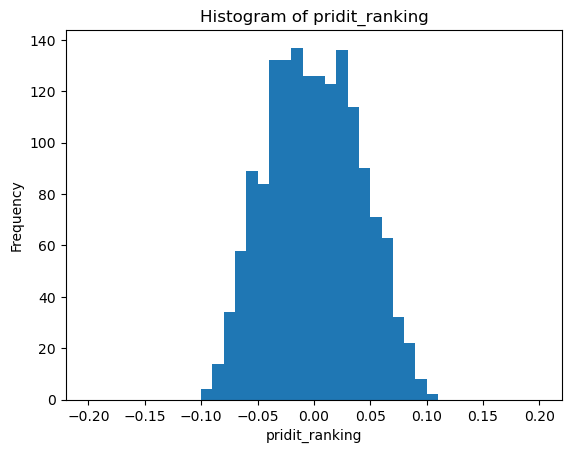

In [36]:
plt.hist(pridit_score['pridit_ranking'], bins=40, range=[-0.2, 0.2])
plt.title(f'Histogram of pridit_ranking')
plt.xlabel('pridit_ranking')
plt.ylabel('Frequency')
plt.show()

In [37]:
pridit_score

,Ticker,OP/SAL,EBIT/TA,GP/FA,NI/CS,GP/SAL,GP/TA,NI/EQ,CS/GP,GP/CS,NI/TA,OP/GP,RE/TA,NI/SAL,TAc/TA,CFO/CS,CFO/SAL,NI/CFO,CFO/TA,CFO/NI,LEV,WC/TA,CASH/CL,CASH/CA,CASH/TA,CA/CL,CL/TL,BV/TL,CA/TL,CFO/TL,EQ/TA,EQ/LA,(CA– INV)/CL,SAL/FA,SAL/TA,FA/TA,SAL/CS,SAL/COST,SAL/GA,INV/TA,INV/CA,INV/CS,REC/REV,DSRI,AQI,DEPI,TATA,GMI,SGI,SGAI,LVGI,RSST,REC,INV,SOFTASSETS,CASHSALES,ROA,ISSUE,pridit_ranking
0,A32,0.05785,0.08632,0.66586,-0.06488,0.10925,0.16301,0.17384,-8.15347,-0.12265,0.08623,0.52955,0.12661,0.05779,0.07747,-0.00659,0.00587,9.83866,0.00876,0.10164,0.50395,0.22653,0.18026,0.12436,0.09084,1.44950,1.00000,0.98431,1.44950,0.01739,0.49605,1.84050,0.67556,6.09490,1.49209,0.24481,0.99933,1.00778,1.15423,0.39003,0.53394,-0.29346,0.16720,0.96777,0.99271,1.00000,0.07756,0.99968,1.12064,0.86638,0.91858,0.10974,0.01868,-0.00349,0.66435,1.00673,0.01850,0,0.00915
1,AAA,0.04767,0.04132,0.34603,-0.04257,0.10459,0.09066,0.07037,-8.56136,-0.11680,0.03304,0.45580,0.06637,0.03812,-0.03844,-0.09209,0.08246,0.46229,0.07148,2.16313,0.53043,0.08440,0.25544,0.21435,0.11246,1.19169,0.83002,0.88527,0.98913,0.13476,0.46957,0.98787,0.94074,3.30851,0.86687,0.26201,1.00622,1.02065,1.24760,0.11049,0.21059,-0.14234,0.24811,1.64481,0.75879,1.19164,-0.03016,1.00294,0.56521,0.80154,1.15014,-0.05532,-0.01360,-0.00544,0.62553,0.89798,-0.00068,0,0.00161
2,AAM,-0.13155,-0.07543,0.01826,0.09912,0.00122,0.00070,-0.06166,-108.67831,-0.00122,-0.05677,-66.76214,-0.00949,-0.09900,0.05855,0.20135,-0.20111,0.49225,-0.11532,2.03148,0.07930,0.73892,1.69371,0.15331,0.12456,11.04784,0.92735,11.61010,10.24519,-1.45418,0.92070,4.90932,3.34679,15.01593,0.57341,0.03819,0.94544,0.91798,0.71142,0.56634,0.69706,-0.98886,0.14225,2.45637,0.94042,1.14033,0.03989,0.97273,0.90140,1.40563,2.42235,-0.01297,0.04579,0.16780,0.83726,0.91047,-0.05918,0,-0.02909
3,AAS,0.02876,0.02223,5.10599,-0.00675,0.02221,0.01717,0.00959,-44.01779,-0.02272,0.00510,1.29493,0.04904,0.00660,-0.07023,-0.09969,0.09747,0.06773,0.07533,14.76504,0.46799,0.50338,0.85990,0.40713,0.38922,2.11212,0.96720,1.13682,2.04283,0.16096,0.53201,12.09566,2.11212,229.86042,0.77278,0.00336,0.50187,0.50985,1.11690,0.00000,0.00000,-0.00000,0.20867,2.33362,15.66364,0.96160,-0.05310,0.75373,0.52516,0.89533,1.78564,-0.50930,0.01683,0.00000,0.60742,0.86904,-0.18822,0,0.00891
4,AAT,0.08301,0.04110,0.12429,-0.05593,0.12573,0.06225,0.03304,-6.95349,-0.14381,0.02421,0.66023,0.13189,0.04890,0.02245,-0.00406,0.00355,13.77394,0.00176,0.07260,0.26718,0.13864,0.21399,0.11430,0.03402,1.87212,0.59499,2.74274,1.11389,0.00658,0.73282,1.04332,1.68777,0.98857,0.49511,0.50084,1.00375,0.99240,0.76007,0.02931,0.09847,-0.06770,0.52061,1.04716,0.59763,1.00000,0.03934,1.00175,0.60675,1.31566,0.81051,-0.22272,-0.09916,-0.00106,0.46514,0.96184,-0.01035,0,0.00762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1592,XPH,-0.06113,-0.01499,0.28628,-0.00112,0.23359,0.05727,0.00022,-3.28105,-0.30478,0.00021,-0.26169,-0.16045,0.00086,0.13606,0.72299,-0.55411,-0.00155,-0.13584,-136.24015,0.02639,0.34522,1.50844,0.10503,0.03897,14.36231,0.98090,21.60266,13.30638,-2.20922,0.95576,1.54808,9.72034,1.22556,0.24516,0.20004,1.13931,1.21254,1.40295,0.11993,0.32321,-0.63827,0.40467,0.91159,1.17857,0.94157,0.12086,1.06045,0.96749,0.71278,1.48537,0.05843,-0.01392,-0.02652,0.76099,1.07057,0.08148,0,-0.01147
1593,YBC,0.04478,0.04359,0.15412,-0.00231,0.07194,0.07004,0.01515,-12.90044,-0.07752,0.00209,0.62240,-0.03946,0.00215,0.02408,0.02434,-0.02259,-0.09507,-0.02199,-10.51819,0.86198,-0.33153,0.01160,0.01968,0.00938,0.58968,0.93734,0.16012,0.55273,-0.02551,0.13802,0.26362,0.28057,2.14234,0.97358,0.45444,1.00376,1.00114,0.91185,0.24974,0.52419,-0.27641,0.22600,0.83668,0.74727,1.12244,0.06558,1.00181,0.97785,1.09667,1.03548,-0.00718,-0.04690,0.02122,0.53618,1.05866,-0.00051,0,-0.06805
1594,YBM,0.

# Evaluation

In [40]:
df_with_score.iloc[:, :4]

,Ticker,mscore,fscore,zscore
0,A32,-2.79397,0.49848,6.76237
1,AAA,-3.86643,0.37259,5.22722
2,AAM,-3.63254,0.88322,19.75009
3,AAS,1.69346,0.32348,8.05510
4,AAT,-3.62432,0.19660,7.74551
...,...,...,...,...
1592,XPH,-2.79161,0.49522,27.57365
1593,YBC,-3.15123,0.31644,1.40760
1594,YBM,-3.37026,0.26232,4.99280
1595,YEG,-1.87321,15.31524,5.98909


In [41]:
pridit_score = pd.merge(df_with_score.iloc[:, :4], pridit_score, on='Ticker', how='inner')
pridit_score

,Ticker,mscore,fscore,zscore,OP/SAL,EBIT/TA,GP/FA,NI/CS,GP/SAL,GP/TA,NI/EQ,CS/GP,GP/CS,NI/TA,OP/GP,RE/TA,NI/SAL,TAc/TA,CFO/CS,CFO/SAL,NI/CFO,CFO/TA,CFO/NI,LEV,WC/TA,CASH/CL,CASH/CA,CASH/TA,CA/CL,CL/TL,BV/TL,CA/TL,CFO/TL,EQ/TA,EQ/LA,(CA– INV)/CL,SAL/FA,SAL/TA,FA/TA,SAL/CS,SAL/COST,SAL/GA,INV/TA,INV/CA,INV/CS,REC/REV,DSRI,AQI,DEPI,TATA,GMI,SGI,SGAI,LVGI,RSST,REC,INV,SOFTASSETS,CASHSALES,ROA,ISSUE,pridit_ranking
0,A32,-2.79397,0.49848,6.76237,0.05785,0.08632,0.66586,-0.06488,0.10925,0.16301,0.17384,-8.15347,-0.12265,0.08623,0.52955,0.12661,0.05779,0.07747,-0.00659,0.00587,9.83866,0.00876,0.10164,0.50395,0.22653,0.18026,0.12436,0.09084,1.44950,1.00000,0.98431,1.44950,0.01739,0.49605,1.84050,0.67556,6.09490,1.49209,0.24481,0.99933,1.00778,1.15423,0.39003,0.53394,-0.29346,0.16720,0.96777,0.99271,1.00000,0.07756,0.99968,1.12064,0.86638,0.91858,0.10974,0.01868,-0.00349,0.66435,1.00673,0.01850,0,0.00915
1,AAA,-3.86643,0.37259,5.22722,0.04767,0.04132,0.34603,-0.04257,0.10459,0.09066,0.07037,-8.56136,-0.11680,0.03304,0.45580,0.06637,0.03812,-0.03844,-0.09209,0.08246,0.46229,0.07148,2.16313,0.53043,0.08440,0.25544,0.21435,0.11246,1.19169,0.83002,0.88527,0.98913,0.13476,0.46957,0.98787,0.94074,3.30851,0.86687,0.26201,1.00622,1.02065,1.24760,0.11049,0.21059,-0.14234,0.24811,1.64481,0.75879,1.19164,-0.03016,1.00294,0.56521,0.80154,1.15014,-0.05532,-0.01360,-0.00544,0.62553,0.89798,-0.00068,0,0.00161
2,AAM,-3.63254,0.88322,19.75009,-0.13155,-0.07543,0.01826,0.09912,0.00122,0.00070,-0.06166,-108.67831,-0.00122,-0.05677,-66.76214,-0.00949,-0.09900,0.05855,0.20135,-0.20111,0.49225,-0.11532,2.03148,0.07930,0.73892,1.69371,0.15331,0.12456,11.04784,0.92735,11.61010,10.24519,-1.45418,0.92070,4.90932,3.34679,15.01593,0.57341,0.03819,0.94544,0.91798,0.71142,0.56634,0.69706,-0.98886,0.14225,2.45637,0.94042,1.14033,0.03989,0.97273,0.90140,1.40563,2.42235,-0.01297,0.04579,0.16780,0.83726,0.91047,-0.05918,0,-0.02909
3,AAS,1.69346,0.32348,8.05510,0.02876,0.02223,5.10599,-0.00675,0.02221,0.01717,0.00959,-44.01779,-0.02272,0.00510,1.29493,0.04904,0.00660,-0.07023,-0.09969,0.09747,0.06773,0.07533,14.76504,0.46799,0.50338,0.85990,0.40713,0.38922,2.11212,0.96720,1.13682,2.04283,0.16096,0.53201,12.09566,2.11212,229.86042,0.77278,0.00336,0.50187,0.50985,1.11690,0.00000,0.00000,-0.00000,0.20867,2.33362,15.66364,0.96160,-0.05310,0.75373,0.52516,0.89533,1.78564,-0.50930,0.01683,0.00000,0.60742,0.86904,-0.18822,0,0.00891
4,AAT,-3.62432,0.19660,7.74551,0.08301,0.04110,0.12429,-0.05593,0.12573,0.06225,0.03304,-6.95349,-0.14381,0.02421,0.66023,0.13189,0.04890,0.02245,-0.00406,0.00355,13.77394,0.00176,0.07260,0.26718,0.13864,0.21399,0.11430,0.03402,1.87212,0.59499,2.74274,1.11389,0.00658,0.73282,1.04332,1.68777,0.98857,0.49511,0.50084,1.00375,0.99240,0.76007,0.02931,0.09847,-0.06770,0.52061,1.04716,0.59763,1.00000,0.03934,1.00175,0.60675,1.31566,0.81051,-0.22272,-0.09916,-0.00106,0.46514,0.96184,-0.01035,0,0.00762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1592,XPH,-2.79161,0.49522,27.57365,-0.06113,-0.01499,0.28628,-0.00112,0.23359,0.05727,0.00022,-3.28105,-0.30478,0.00021,-0.26169,-0.16045,0.00086,0.13606,0.72299,-0.55411,-0.00155,-0.13584,-136.24015,0.02639,0.34522,1.50844,0.10503,0.03897,14.36231,0.98090,21.60266,13.30638,-2.20922,0.95576,1.54808,9.72034,1.22556,0.24516,0.20004,1.13931,1.21254,1.40295,0.11993,0.32321,-0.63827,0.40467,0.91159,1.17857,0.94157,0.12086,1.06045,0.96749,0.71278,1.48537,0.05843,-0.01392,-0.02652,0.76099,1.07057,0.08148,0,-0.01147
1593,YBC,-3.15123,0.31644,1.40760,0.04478,0.04359,0.15412,-0.00231,0.07194,0.07004,0.01515,-12.90044,-0.07752,0.00209,0.62240,-0.03946,0.00215,0.02408,0.02434,-0.02259,-0.09507,-0.02199,-10.51819,0.86198,-0.33153,0.01160,0.01968,0.00938,0.58968,0.93734,0.16012,0.55273,-0.02551,0.13802,0.26362,0.28057,2.14234,0

In [50]:
def check_overlapping(pridit_score, score_name, threshold,ver='none'):
    flagged_pridit_score = pridit_score.sort_values(by='pridit_ranking',ascending = True)[:threshold]
    
    if score_name == 'mscore':
        overlap_score = flagged_pridit_score[flagged_pridit_score[score_name] > -1.78]
    elif score_name == 'fscore':
        if ver == 'high':
            overlap_score = flagged_pridit_score[flagged_pridit_score[score_name] > 1.85]
        if ver == 'moderate':
            overlap_score = flagged_pridit_score[flagged_pridit_score[score_name] > 1]
    elif score_name == 'zscore':
        overlap_score = flagged_pridit_score[flagged_pridit_score[score_name] < 1.1]
    
    print("Number of overlapping firms", len(overlap_score))
    print("Percentage of overlapping firms", len(overlap_score)/ len(flagged_pridit_score))
    return overlap_score

In [56]:
overlap_mscore_1 = check_overlapping(pridit_score, 'mscore', 50)

Number of overlapping firms 8
Percentage of overlapping firms 0.16


In [57]:
overlap_fscore_1 = check_overlapping(pridit_score, 'fscore', 50, 'high')

Number of overlapping firms 2
Percentage of overlapping firms 0.04


In [58]:
overlap_fscore_2 = check_overlapping(pridit_score, 'fscore', 50, 'moderate')

Number of overlapping firms 10
Percentage of overlapping firms 0.2


In [59]:
overlap_zscore_1 = check_overlapping(pridit_score,'zscore', 50)

Number of overlapping firms 26
Percentage of overlapping firms 0.52
